## Regression of Edmunds Consumer Car Dataset

Dataset Source: https://www.kaggle.com/datasets/ankkur13/edmundsconsumer-car-ratings-and-reviews

#### Import Necessary Libraries

In [1]:
import sys, os, math, random, re, logging
os.environ['TOKENIZERS_PARALLELISM']='false'

import glob

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_error, r2_score

from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, set_seed, get_scheduler

from datasets import Dataset, DatasetDict

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Display Versions of Relevant Libraries, Frameworks, Languages, etc. Used in This Project

In [2]:
print("Python Version:".rjust(18), sys.version[0:6])
print("NumPy Version:".rjust(18), np.__version__)
print("Pandas Version:".rjust(18), pd.__version__)
print("Torch Version:".rjust(18), torch.__version__)

   Python Version: 3.9.12
    NumPy Version: 1.23.3
   Pandas Version: 1.5.0
    Torch Version: 1.12.1


### Data Ingestion & Preprocessing

#### Data Ingestion

In [3]:
data_folder = "/Users/briandunn/Documents/nlpnn/Datasets/Car_Reviews"
folder_concat = '/Users/briandunn/Documents/nlpnn/Datasets/Car_Reviews/Scraped_Car_Review_'
files_to_keep = ["Toyota", "Honda", "nissan", "subaru", "mitsubishi", "mazda"]
file_type=".csv"

all_files = glob.glob(os.path.join(data_folder, "*.csv"))
fileset = [x for x in all_files if x.split("Scraped_Car_Review_")[-1].split(".")[0] in files_to_keep]

df = pd.concat((pd.read_csv(f, on_bad_lines="skip", lineterminator='\n') for f in fileset), ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62491 entries, 0 to 62490
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     62491 non-null  int64  
 1   Review_Date    62491 non-null  object 
 2   Author_Name    62491 non-null  object 
 3   Vehicle_Title  62491 non-null  object 
 4   Review_Title   62488 non-null  object 
 5   Review         62491 non-null  object 
        62491 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 3.3+ MB


#### Data Preprocessing (Part 1)

In [4]:
# drop duplicate reviews
df.drop_duplicates(inplace=True)

# Features to drop, if they still are included in the dataframe
cols_to_check = ["Vehicle_Title", "Unnamed: 0", "Review_Date", "Author_Name", "level_0", "index"] 
cols_to_drop = []
for x in cols_to_check:
    if x in df.columns:
        cols_to_drop.append(x)

df.drop(columns=cols_to_drop, inplace=True)

# concatenate the review title and text and rename it to 'text' (use ' : ' as the seperator)
df["text"] = df["Review_Title"] + " : " + df["Review"]

'''
Since there were only 13 missing values (all of them are review titles) 
out of 226,000+ samples in the original dataset, I am just going to drop
those samples. It looks like only 3 of these missing values were 
from this section of the dataset.
'''
review_title_feature = "Review_Title"
if review_title_feature in df.columns:
    df.dropna(axis=0, subset=[review_title_feature], inplace=True)

df

,Review_Title,Review,Rating\r,text
0,QUIRKY AND PRACTICAL,4 years with our element. Honestly there isn'...,4.0,QUIRKY AND PRACTICAL : 4 years with our eleme...
1,Go Anywhere with your Element,I have owned my Element since 2007 when I pur...,5.0,Go Anywhere with your Element : I have owned ...
2,Such a cool car!,Lowest maintenance of any vehicle I've ever o...,1.0,Such a cool car! : Lowest maintenance of any ...
3,"From soup to nuts, it does it all.",The only thing I'd change is the drink holder...,5.0,"From soup to nuts, it does it all. : The only..."
4,good value,I bought this vehicle new in 2007. got 97K mi...,4.0,good value : I bought this vehicle new in 200...
...,...,...,...,...
62486,Get car to build credit,I got my 2017 Nissan Versa back in March of t...,4.0,Get car to build credit : I got my 2017 Nissa...
62487,good for the elderly,We liked the car very much. However the deale...,4.0,good for the elderly : We liked the car very ...
62488,Warranted if not driven outside,AC condenser not covered if (and apparently c...,3.0,Warranted if not driven outside : AC condense...
62489,reliable transportation,this is not a sports car but it is reliable t...,5.0,reliable transportation : this is not a sport...


#### Data Preprocessing (Part 2)

In [5]:
ratings_col = "Rating\r"
if ratings_col in df.columns:
    df["Rating\r"] = df["Rating\r"].astype(float)
    df.rename(columns={"Rating\r" : "label"}, inplace=True)

# Drop Unused Features
cols_to_check = ["Review_Title", "Review"] 
cols_to_drop = []

for x in cols_to_check:
    if np.any(x in df.columns):
        if np.any("text" in df.columns):
            cols_to_drop.append(x)

df.drop(columns=cols_to_drop, inplace=True)

df

,label,text
0,4.0,QUIRKY AND PRACTICAL : 4 years with our eleme...
1,5.0,Go Anywhere with your Element : I have owned ...
2,1.0,Such a cool car! : Lowest maintenance of any ...
3,5.0,"From soup to nuts, it does it all. : The only..."
4,4.0,good value : I bought this vehicle new in 200...
...,...,...
62486,4.0,Get car to build credit : I got my 2017 Nissa...
62487,4.0,good for the elderly : We liked the car very ...
62488,3.0,Warranted if not driven outside : AC condense...
62489,5.0,reliable transportation : this is not a sport...


#### Visulatization: Distribution of

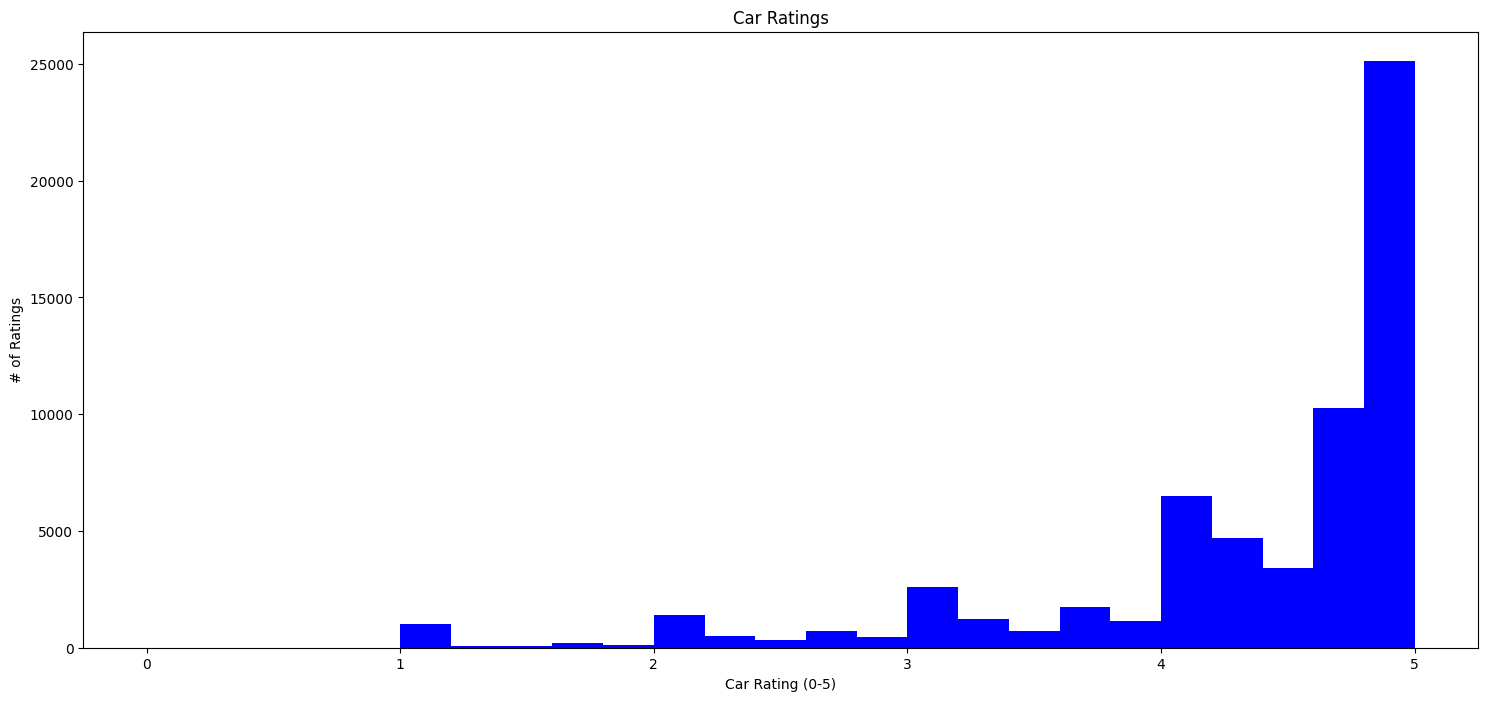

In [6]:
df.hist("label", color="Blue", grid=False, bins=25, figsize=(18,8), range=(0,5))
plt.suptitle('')
plt.title('Car Ratings')
plt.xlabel('Car Rating (0-5)')
plt.ylabel('# of Ratings')
plt.show()

#### Visualiation of Input Length

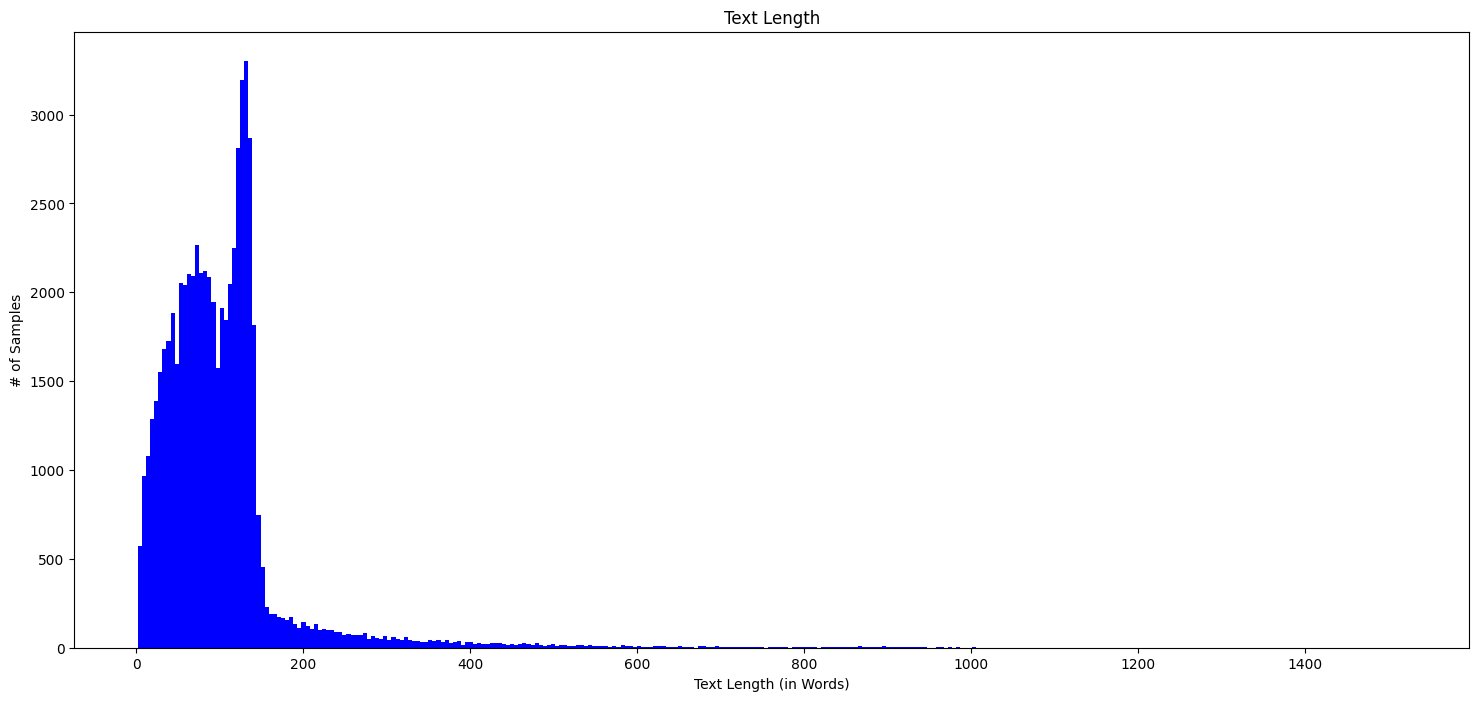

In [7]:
df['Text Length'] = df['text'].str.split().apply(len)

df.hist("Text Length", color="Blue", grid=False, bins=310, figsize=(18,8))
plt.suptitle('')
plt.xlabel('Text Length (in Words)')
plt.ylabel('# of Samples')
plt.show()

#### Drop Unnecessary Features & Trim Overly Lengthy Reviews

In [8]:
df = df[df["Text Length"] < 151]

df.drop(columns=["Text Length"], inplace=True)

df.reset_index(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57150 entries, 0 to 57149
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   57150 non-null  int64  
 1   label   57150 non-null  float64
 2   text    57150 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


/var/folders/93/v_c2ph_17t97zdkzc4_ccjtw0000gn/T/ipykernel_44844/3607917477.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["Text Length"], inplace=True)


### Actual Project

#### Convert Pandas DataFrame to Datasets

In [9]:
dataset = Dataset.from_pandas(df)

#### Split Dataset into Training & Testing Dataset

In [10]:
train_testvalid = dataset.train_test_split(test_size=0.20)
test_valid = train_testvalid['test'].train_test_split(test_size=0.50)

ds = DatasetDict({
    'train' : train_testvalid['train'],
    'test' : test_valid['test'],
    'eval' : test_valid['train']
})

print('Training data shape:', ds['train'].shape)
print('Testing data shape:', ds['test'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (45720, 3)
Testing data shape: (5715, 3)
Eval data shape: (5715, 3)


##### Basic Values

In [11]:
NUM_OF_EPOCHS = 3
MAX_INPUT_LEN = int(round(150*1.3, 0))

MODEL_CKPT = "distilbert-base-uncased"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_LABELS = 1
BATCH_SIZE = 64

MODEL_NAME = f"{MODEL_CKPT}-Regression-Edmunds_Car_Reviews-Non_European_Imports"
LEARNING_RATE = 2e-5

set_seed(42)

#### HuggingFace Access Token & Install git lfs

In [12]:
# HuggingFace Access Token ... 

!git lfs install

Git LFS initialized.


#### Tokenize Entire Dataset

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=MAX_INPUT_LEN, return_tensors="np")

encoded_ds = ds.map(tokenize, batched=True, batch_size=None)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

#### Print Example to Ensure Edits Worked As Expected

In [14]:
print(encoded_ds['train'].features)
print(encoded_ds['train'])

{'index': Value(dtype='int64', id=None), 'label': Value(dtype='float64', id=None), 'text': Value(dtype='string', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['index', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 45720
})


#### Initialize Model

In [15]:
model = (AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT, num_labels=NUM_LABELS)).to(DEVICE)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

#### Metrics Evaluation Function

In [16]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
        
    return {"mae": mae, "mse": mse, "rmse": rmse}

#### Trainer Arguments

In [17]:
training_args = TrainingArguments(output_dir=MODEL_NAME, 
                                  num_train_epochs=NUM_OF_EPOCHS, 
                                  per_device_train_batch_size=BATCH_SIZE, 
                                  per_device_eval_batch_size=BATCH_SIZE, 
                                  weight_decay=0.01,
                                  learning_rate=LEARNING_RATE,
                                  no_cuda=True,
                                  evaluation_strategy='epoch',
                                  save_total_limit=10,
                                  logging_strategy='epoch',
                                  load_best_model_at_end=True,
                                  metric_for_best_model='mae',
                                  greater_is_better=False,
                                  save_strategy='epoch',
                                  push_to_hub=True)

####  Build Trainer

In [18]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=encoded_ds['train'], 
                  eval_dataset=encoded_ds['eval'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics_for_regression)

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/huggingface_hub/repository.py:705: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports into local empty directory.


#### Train Trainer

In [19]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 45720
  Num Epochs = 3
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 2145


A Jupyter Widget

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5715
  Batch size = 64


{'loss': 0.6594, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-715
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-715/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-715/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-715/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-715/special_tokens_map.json


{'eval_loss': 0.2435894012451172, 'eval_mae': 0.33187228441238403, 'eval_mse': 0.2435893714427948, 'eval_rmse': 0.4935477375984192, 'eval_runtime': 2483.9701, 'eval_samples_per_second': 2.301, 'eval_steps_per_second': 0.036, 'epoch': 1.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5715
  Batch size = 64


{'loss': 0.2324, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-1430
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-1430/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-1430/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-1430/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-1430/special_tokens_map.json


{'eval_loss': 0.22740231454372406, 'eval_mae': 0.3209717571735382, 'eval_mse': 0.22740231454372406, 'eval_rmse': 0.4768671989440918, 'eval_runtime': 2449.546, 'eval_samples_per_second': 2.333, 'eval_steps_per_second': 0.037, 'epoch': 2.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5715
  Batch size = 64


{'loss': 0.1975, 'learning_rate': 0.0, 'epoch': 3.0}


A Jupyter Widget

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-2145
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-2145/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-2145/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-2145/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-2145/special_tokens_map.json


{'eval_loss': 0.23033222556114197, 'eval_mae': 0.31982067227363586, 'eval_mse': 0.23033222556114197, 'eval_rmse': 0.4799293875694275, 'eval_runtime': 2479.8101, 'eval_samples_per_second': 2.305, 'eval_steps_per_second': 0.036, 'epoch': 3.0}


tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/checkpoint-2145 (score: 0.31982067227363586).


{'train_runtime': 185157.7222, 'train_samples_per_second': 0.741, 'train_steps_per_second': 0.012, 'train_loss': 0.3631247922812864, 'epoch': 3.0}


TrainOutput(global_step=2145, training_loss=0.3631247922812864, metrics={'train_runtime': 185157.7222, 'train_samples_per_second': 0.741, 'train_steps_per_second': 0.012, 'train_loss': 0.3631247922812864, 'epoch': 3.0})

### Evaluate Model

#### Generate Predictions

In [20]:
trainer.eval_dataset = encoded_ds['test']
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: index, text. If index, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5715
  Batch size = 64


A Jupyter Widget

{'eval_loss': 0.22400729358196259,
 'eval_mae': 0.3140411078929901,
 'eval_mse': 0.22400729358196259,
 'eval_rmse': 0.47329407930374146,
 'eval_runtime': 2456.1079,
 'eval_samples_per_second': 2.327,
 'eval_steps_per_second': 0.037,
 'epoch': 3.0}

#### Push Model to Hub

In [21]:
trainer.push_to_hub(commit_message="All Dunn!!!")

Saving model checkpoint to distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports
Configuration saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/config.json
Model weights saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/DunnBC22/distilbert-base-uncased-Regression-Edmunds_Car_Reviews-Non_European_Imports
   3916534..074b869  main -> main



### Notes & Other Takeaways From This Project
****
- Based on the results of the first two (related) projects, these results are not surprising.
****